Run the following code to import the required packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline

## Multiple Linear Regression with Categorical Explanatory Variables

So far, we've only considered numerical explanatory variables. What if we also consider categorical variables, like player position? Let's analyze the following fantasy football dataset I created by merging ESPN projections located here:

https://www.espn.com/fantasy/football/story/_/page/17RanksPreseason200PPR/2017-fantasy-football-ppr-rankings-top-200

with how players actually performed that season:

In [2]:
df = pd.read_csv('data/football.csv', index_col=0)
df.head()

,player,positions,2017 projected ranking,2017 actual points scored
0,"Russell Wilson, SEA",QB,79,347.9
1,"Le'Veon Bell, PIT",RB,2,341.6
2,"Alvin Kamara, NO",RB,152,320.4
3,"Antonio Brown, PIT",WR,3,310.3
6,"Tom Brady, NE",QB,44,295.9


We can reduce our dataset to purely the numerical columns:

In [3]:
df = df.drop(columns=['player', 'positions'])
df.head()

,2017 projected ranking,2017 actual points scored
0,79,347.9
1,2,341.6
2,152,320.4
3,3,310.3
6,44,295.9


Let's view a scatterplot of the data:

Text(0, 0.5, 'actual points scored')

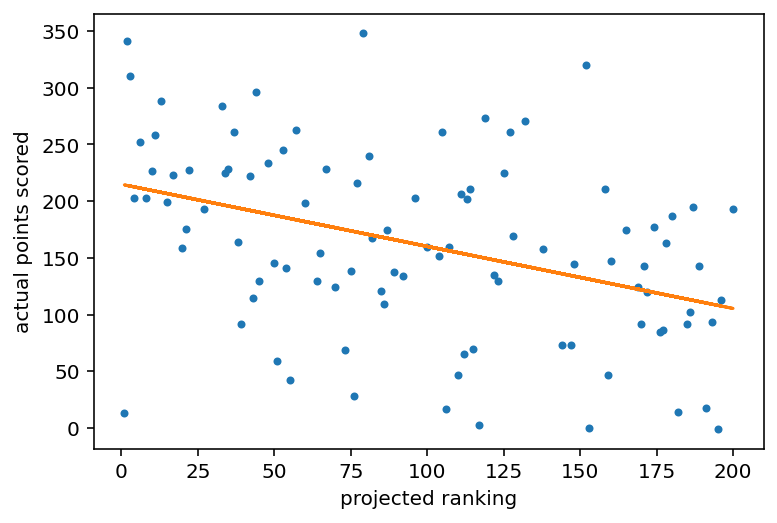

In [4]:
x = df['2017 projected ranking']
y = df['2017 actual points scored']
fit = np.polyfit(x, y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x, y,'.', x, fit_fn(x))
plt.xlabel('projected ranking')
plt.ylabel('actual points scored')

If we do that and run a linear regression, we get an R-squared value of only 16%:

In [5]:
X = df.drop(columns = ['2017 actual points scored'])
y = df['2017 actual points scored']

model = LinearRegression()
model.fit(X, y)
print('R-squared', model.score(X,y))

R-squared 0.15937674459960738


Let's see if we can do better by using categorical variables, too. Our goal will be to use ESPN rankings (numerical) AND player position (categorical) to predict their fantasy points.

Step 1: Create a new dataframe from the original dataframe that includes just your predictor variables, the positions and ranking columns. 

In [6]:
df = pd.read_csv('data/football.csv', index_col=0)
input_data = df[['2017 projected ranking','positions']]
input_data.head()

,2017 projected ranking,positions
0,79,QB
1,2,RB
2,152,RB
3,3,WR
6,44,QB


Step 2: Create a one-hot matrix using pd.dummy that turns the categorical column, position, into numerical columns for each position:

In [7]:
one_hot = pd.get_dummies(df['positions'])
one_hot.head()

,QB,RB,TE,WR
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
6,1,0,0,0


Step 3: We can now merge the two dataframe by first dropping the position labels column, since now each position is treated numerically:

In [8]:
input_data = input_data.drop('positions', axis = 1)
input_data = input_data.join(one_hot)
input_data.head()

,2017 projected ranking,QB,RB,TE,WR
0,79,1,0,0,0
1,2,0,1,0,0
2,152,0,1,0,0
3,3,0,0,0,1
6,44,1,0,0,0


We are now ready to create a linear regression model that predicts actual points scored:

In [9]:
X = input_data
y = df['2017 actual points scored']

model = LinearRegression()
model.fit(X, y)
print('R-squared', model.score(X,y))

R-squared 0.36078149047291974


Wow! Our R-Squared doubled when we added in position.

What exactly is our model?

In [10]:
print(model.intercept_)
print(model.coef_)

232.915387718765
[ -0.60860431  63.39696312 -47.90769248  -6.13379563  -9.35547502]


This means that:

$\text{predicted actual points scored} = 232.9 - 0.61 (\text{projected ranking})+ 63.40 (QB) - 47.91 (RB) - 6.13 (TE) - 9.34 (WR)$

This makes sense since being a QB should indicate that you'll score more points and having a higher ranking (meaning ranking #200 instead of #1) should actually mean that you score less points.

Let's visualize what is going on with this multiple linear regression by creating the following plot below:

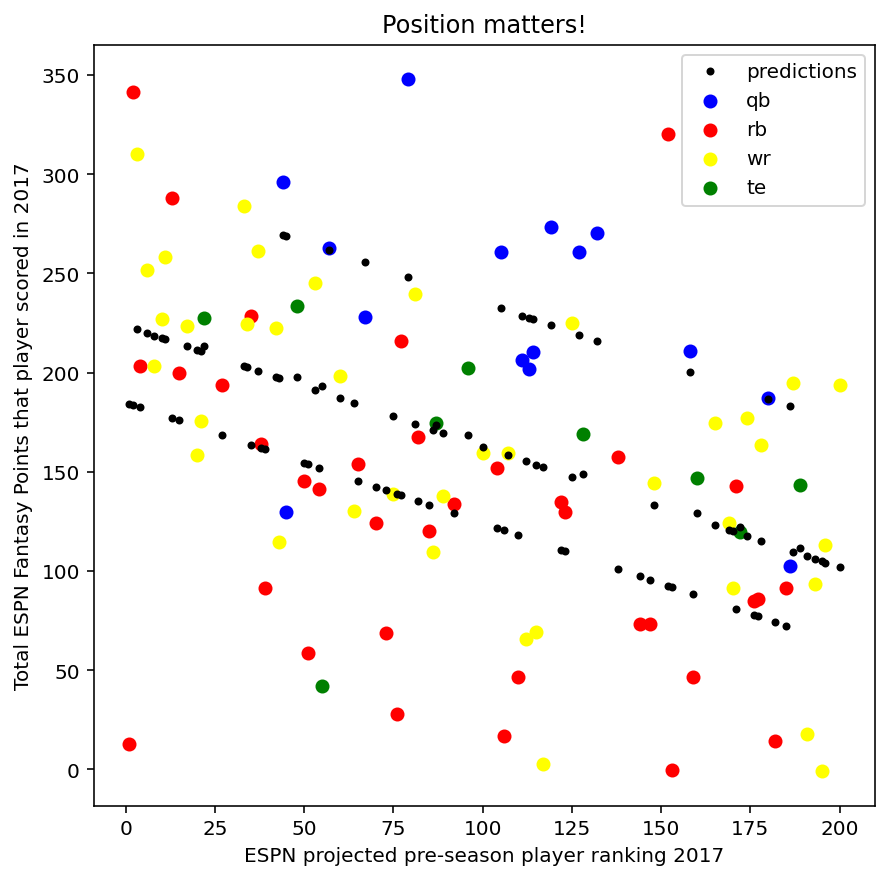

In [11]:
quarterbacks = df[df['positions'] == 'QB']
runningbacks = df[df['positions'] == 'RB']
receivers = df[df['positions'] == 'WR']
tightends = df[df['positions'] == 'TE']

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(quarterbacks['2017 projected ranking'], quarterbacks['2017 actual points scored'],  color='blue', label='qb')
ax.scatter(runningbacks['2017 projected ranking'], runningbacks['2017 actual points scored'],  color='red', label='rb')
ax.scatter(receivers['2017 projected ranking'], receivers['2017 actual points scored'],  color='yellow', label = 'wr')
ax.scatter(tightends['2017 projected ranking'], tightends['2017 actual points scored'],  color='green', label = 'te')

ax.plot(X['2017 projected ranking'].values, model.predict(X), 'k.', label = 'predictions')
ax.set_xlabel('ESPN projected pre-season player ranking 2017')
ax.set_ylabel('Total ESPN Fantasy Points that player scored in 2017')
ax.set_title('Position matters!')
ax.legend(loc='best')

If you look closely, you should actually see four black lines in the plot above, corresponding to a different regression line for each position.

Finally, we can analyze who did best and who did worst.

We can create another column in the results dataframe called "predicted points" that lists the predicted points from the line of best fit for each player and then use that column to calculate the residuals. We can then sort the dataframe by residuals from lowest to highest to see the most overrated players.

In [12]:
df = pd.read_csv('data/football.csv', index_col=0)
df['predicted points'] = fit_fn(df['2017 projected ranking'])
df['residual'] = df['2017 actual points scored'] - df['predicted points']
df.sort_values(by = 'residual', ascending = True).head()

,player,positions,2017 projected ranking,2017 actual points scored,predicted points,residual
114,"David Johnson, ARI",RB,1,13.0,214.359877,-201.359877
117,"Kevin White, CHI",WR,117,2.6,150.827850,-148.227850
109,"Terrance West, BAL",RB,76,28.1,173.283135,-145.183135
107,"Greg Olsen, CAR",TE,55,42.1,184.784623,-142.684623
112,"C.J. Prosise, SEA",RB,106,17.0,156.852439,-139.852439


It makes sense that David Johnson was the most overrated player that year, as he was ranked #1 but unfortunately got injured early in the season. 